# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [2]:
# your code here


def gini_index(labels):
    if len(labels) == 0: return 0
    class1_length = len(labels[labels == 0])
    p = class1_length/len(labels)
    return 2*p*(1-p)

def misclassification(labels):
    if len(labels) == 0: return 0
    class1_length = len(labels[labels == 0])
    p = class1_length/len(labels)
    return min(p,1-p)

def entropy(labels):
    if len(labels) == 0: return 0
    class1_length = len(labels[labels == 0])
    p = class1_length/len(labels)
    q = 1-p
    if p == 0 or q == 0:
        return 0
    else:
        return -p*math.log2(p)-q*math.log2(q)


labels = np.array([0,0,0,1])
print(gini_index(labels),misclassification(labels),entropy(labels))


0.375 0.25 0.8112781244591328


### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [3]:
max_depth = 3
class Node(object):
    def __init__(self,is_leaf=False):
        self.value = None
        self.left = None
        self.right = None
        self.error = None
        self.col= None
        self.is_leaf = is_leaf

def build_internal(df):
    cols = list(df.columns[:-1])
    min_error = {}
    min_index = {}
    threshold = {}
    total = df.shape[0]
    for col in cols:
        min_error[col] = 1
        min_index[col] = 0
        
    for col in cols:
        temp = df.sort_values(col)

        for i in range(total):
            if i != 0 and temp.iloc[i][col] == temp.iloc[i-1][col]: continue
            error1 = gini_index(temp.iloc[0:i].label)
            error2 = gini_index(temp.iloc[i:].label)
            error = i/total * error1 + (total-i)/total*error2
            if error < min_error[col]:
                    min_error[col] = error
                    min_index[col] = i 

        if i == 0:
            threshold[col] = math.floor(temp.iloc[0].x1)
        else: threshold[col] = (temp.iloc[min_index[col]][col] + temp.iloc[min_index[col]-1][col])/2
    return min_error,threshold

def build_tree(depth,df):
    error = gini_index(df.label)
    newNode = Node()

    if error == 0 or depth == max_depth: # leaf node
        newNode.is_leaf = True
        newNode.error = error
        newNode.value = np.bincount(df["label"]).argmax() 
        
    else: 
        loss,threshold = build_internal(df)
        newNode.error = min(loss.values())
        newNode.col = [key for key,value in loss.items() if value == newNode.error][0]
        newNode.value = threshold[newNode.col]
        left_df = df[df[newNode.col] < newNode.value].drop(newNode.col,axis=1)
        right_df = df[df[newNode.col] > newNode.value].drop(newNode.col,axis=1)
        newNode.left = build_tree(depth+1,left_df)
        newNode.right = build_tree(depth+1,right_df)
        

    return newNode

def print_node(root):
    if root.is_leaf: 
        print("label: ",root.value)
        print("loss: ",root.error)
        print(root.is_leaf)
        print('*************')
    else:
        print("threshold: ",root.value)
        print("loss: ",root.error)
        print("column: ",root.col)
        print(root.is_leaf)
        print('*************')

def traverse(nodes):
    if len(nodes) == 0: return
    print_node(nodes[0])
    cur = nodes.pop(0)
    if not cur.is_leaf: 
        nodes.append(cur.left)
        nodes.append(cur.right)
    traverse(nodes)

def predict(root,row):
    if root is None: return None 
    if root.is_leaf: return root.value
    else: 
        if row[root.col] < root.value: return predict(root.left,row)
        else: return predict(root.right,row)
    
    


### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

`DecisionTreeClassifier` is used for classification task(prediction of discrete variable having finite number of classes) and `DecisionTreeRegressor` is used for regression task(prediction of continous variable). Since in this example, we need to predict whether the note is authentic or not which is a discrete variable having two classes, `DecisionTreeClassifier` will be used. 

In [4]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

In [5]:
def decision_tree_exp(max_depth=None,criterion="gini",min_samples_split=2,plot=False):

    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(max_depth=max_depth,criterion=criterion,min_samples_split=min_samples_split)

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy = metrics.accuracy_score(y_test, y_pred_test)

    if plot: 
        plotTree(clf)

    return train_accuracy,test_accuracy


### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [6]:
df = pd.read_csv('bankAuth.txt',header=None)

In [7]:
# your code here
df.columns = ["x1","x2","x3","x4","label"]

In [8]:
df.head()

,x1,x2,x3,x4,label
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1372 non-null   float64
 1   x2      1372 non-null   float64
 2   x3      1372 non-null   float64
 3   x4      1372 non-null   float64
 4   label   1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [10]:
df.label.value_counts()

0    762
1    610
Name: label, dtype: int64

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [24]:
# your code here

from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df.label

train_df, test_df = train_test_split(df)
X_train, X_test, y_train, y_test = train_test_split(X, y)




### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

### Custom Decision tree 

In [12]:
root = build_tree(1,train_df)

In [13]:
traverse([root])

threshold:  0.320165
loss:  0.23384681625629264
column:  x1
False
*************
threshold:  5.86535
loss:  0.15806682619028004
column:  x2
False
*************
threshold:  -4.38605
loss:  0.1335158364501488
column:  x3
False
*************
label:  1
loss:  0.0917957174882115
True
*************
label:  0
loss:  0.4272505048357955
True
*************
label:  1
loss:  0.3829344432882414
True
*************
label:  0
loss:  0.11826538908923978
True
*************


In [14]:
pred_labels_test = test_df[["x1","x2","x3","x4"]].apply(lambda x : predict(root,x),axis =1)
pred_labels_train = train_df[["x1","x2","x3","x4"]].apply(lambda x : predict(root,x),axis =1)

In [15]:
metrics.accuracy_score(pred_labels_train,train_df.label) # training data accuracy

0.9135082604470359

In [16]:
metrics.accuracy_score(pred_labels_test,test_df.label) # testing data accuracy

0.9067055393586005

### Sklearn Decision Trees

In [17]:
# experimenting with criterion 

criterions = ["gini", "entropy", "log_loss"]
list(map(lambda x : decision_tree_exp(criterion = x),criterions))


[(1.0, 0.9708454810495627),
 (1.0, 0.9737609329446064),
 (1.0, 0.9737609329446064)]

Text(0, 0.5, 'max_depth')

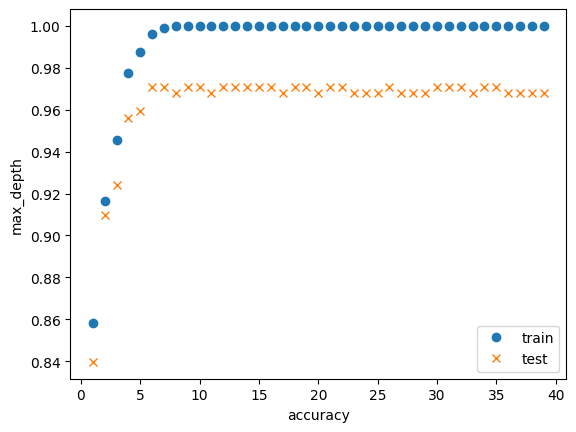

In [18]:
# experimenting with max_depth

max_depths = list(range(1,40,1))
accuracies = list(map(lambda x : decision_tree_exp(max_depth= x),max_depths))
train_accuracies,test_accuracies = list(zip(*accuracies))
plt.plot(max_depths,train_accuracies,"o")
plt.plot(max_depths,test_accuracies,"x")
plt.legend(["train","test"])
plt.xlabel("accuracy")
plt.ylabel("max_depth")


Text(0, 0.5, 'min_samples_split')

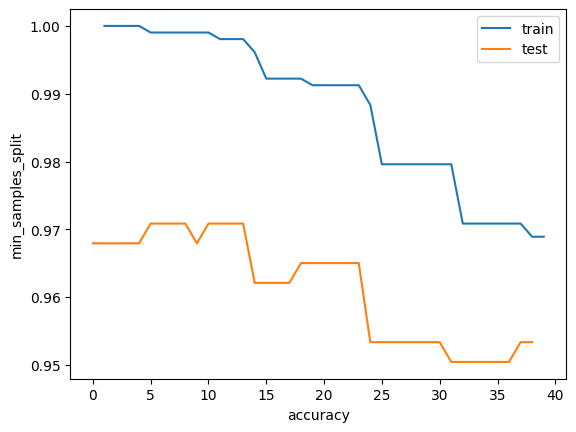

In [19]:
# experimenting with min_sample_split

min_samples_splits = list(range(1,40,1))
accuracies = list(map(lambda x : decision_tree_exp(min_samples_split= x),min_samples_splits))
train_accuracies,test_accuracies = list(zip(*accuracies))
plt.plot(min_samples_splits,train_accuracies,test_accuracies)
plt.legend(["train","test"])
plt.xlabel("accuracy")
plt.ylabel("min_samples_split")

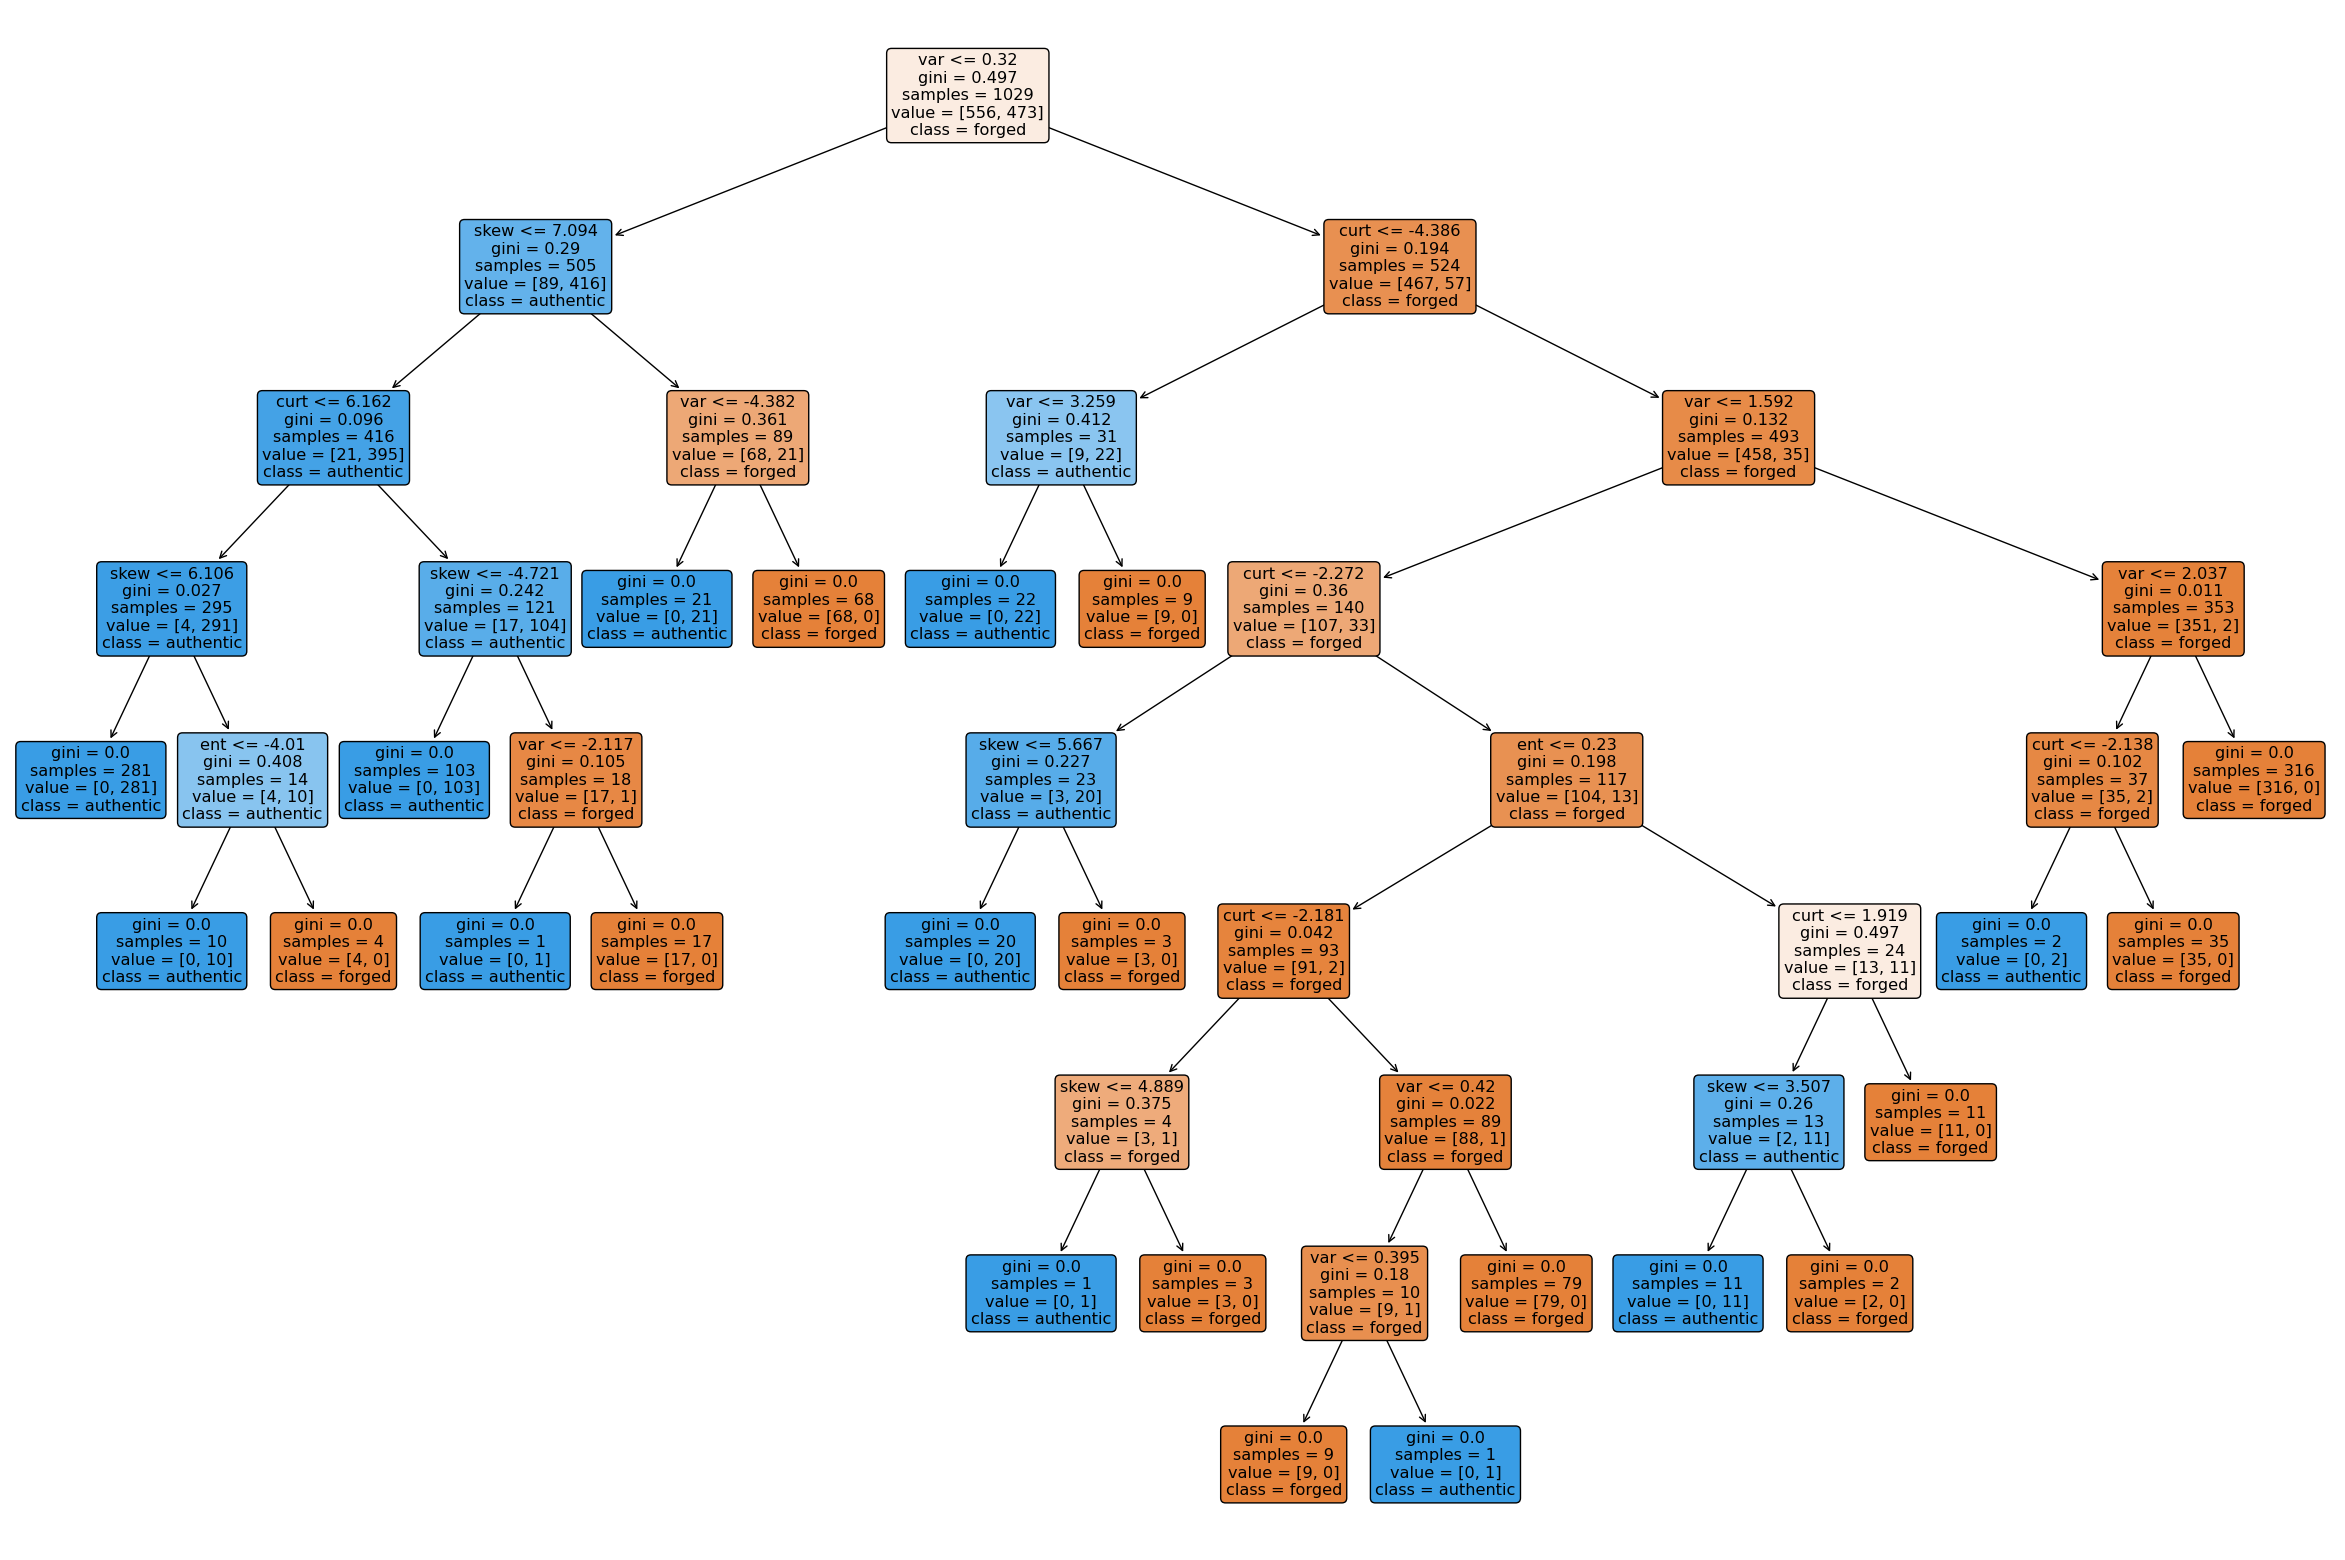

(1.0, 0.967930029154519)

In [20]:
decision_tree_exp(plot=True)